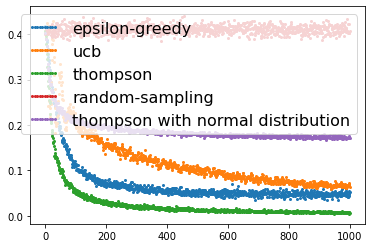

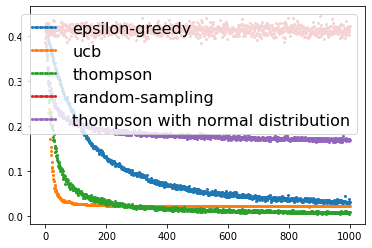

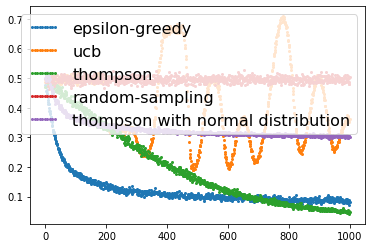

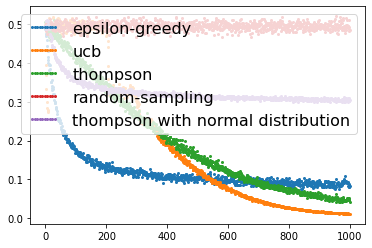

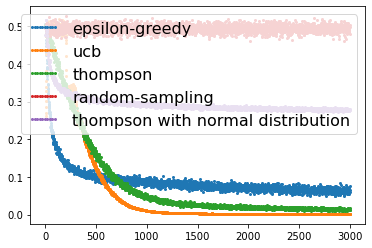

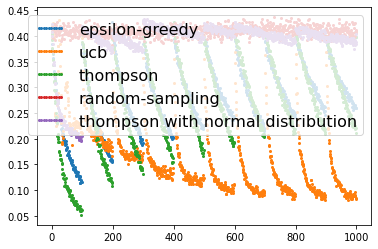

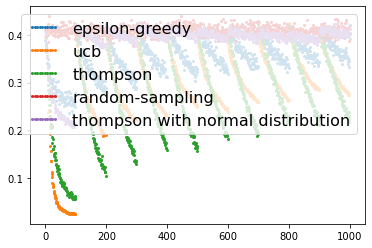

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace


stationary = True

class Bandit():
    def __init__(self, arm_count):
        """
        Multi-armed bandit with rewards 1 or 0.

        At initialization, multiple arms are created. The probability of each arm
        returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
        chosen from Uniform(0,1) at initialization
        """
        self.arm_count = arm_count
        self.generate_thetas()
        self.timestep = 0
        global stationary
        self.stationary = stationary

    def generate_thetas(self):
        self.thetas = np.random.uniform(0, 1, self.arm_count)

        # For manually decide every action like this:
        # self.thetas = np.array([0.5, 0.2, 0.3, 0.1, 0.25, 0.7, 0.1, 0.3, 0.1, 0.25])

        # This could simulate 10 restaurant that I am not very familiar but I can only eat in them in a period of time.
        # These are the probability that whether I feel satisfied if I eat in that restaurant today.
        # Of course, I want to get the best reward (feel satisfied or not) I can get every day in that period.


    def get_reward_regret(self, arm):
        """ Returns random reward for arm action. Assumes actions are 0-indexed
        Args:
          arm is an int
        """
        self.timestep += 1
        if (self.stationary == False) and (self.timestep % 100 == 0):
            self.generate_thetas()
        # Simulate bernouilli sampling
        sim = np.random.uniform(0, 1, self.arm_count)
        rewards = (sim < self.thetas).astype(int)
        reward = rewards[arm]
        regret = self.thetas.max() - self.thetas[arm]

        return reward, regret



# Thompson Sampling:
class BetaAlgo():
    """
    The algos try to learn which Bandit arm is the best to maximize reward.

    It does this by modelling the distribution of the Bandit arms with a Beta,
    assuming the true probability of success of an arm is Bernouilli distributed.
    """

    def __init__(self, bandit):
        """
        Args:
          bandit: the bandit class the algo is trying to model
        """
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.alpha = np.ones(self.arm_count)
        self.beta = np.ones(self.arm_count)

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward


class BernGreedy(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)

    @staticmethod
    def name():
        return 'beta-greedy'

    def get_action(self):
        """ Bernouilli parameters are the expected values of the beta"""
        theta = self.alpha / (self.alpha + self.beta)
        return theta.argmax()


class BernThompson(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)

    @staticmethod
    def name():
        return 'thompson'

    def get_action(self):
        """ Bernouilli parameters are sampled from the beta"""
        theta = np.random.beta(self.alpha, self.beta)
        return theta.argmax()

# Thompson Sampling with normal distribution
class ThompsonNormal(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)

    @staticmethod
    def name():
        return 'thompson with normal distribution'

    def get_action(self):
        theta = np.random.normal(self.alpha, self.beta)
        return theta.argmax()




#  𝜖-greedy algorithm:
epsilon = 0.1  # we need to tune this parameter, 10% turns we try a new machine.
class EpsilonGreedy():
    """
    Epsilon Greedy with incremental update.
    Based on Sutton and Barto pseudo-code, page. 24
    """

    def __init__(self, bandit):
        global epsilon
        self.epsilon = epsilon
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.Q = np.zeros(self.arm_count)  # q-value of actions, q-value = win times / pulling this machine times
        self.N = np.zeros(self.arm_count)  # pulling this machine times

    @staticmethod
    def name():
        return 'epsilon-greedy'

    def get_action(self):
        if np.random.uniform(0, 1) > self.epsilon:
            action = self.Q.argmax()
        else:
            action = np.random.randint(0, self.arm_count)
        return action

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.N[arm] += 1  # increment action count
        self.Q[arm] += 1 / self.N[arm] * (reward - self.Q[arm])  # simplified way to calculate new q-value, in this 0/1 case



# The UCB algorithmn compare the 'whole value' (the math equation in the document)
# and choose the machine with biggest 'whole value'.
ucb_c = 2 # hyperparameter that need to tuning
class UCB():
    """
    Epsilon Greedy with incremental update.
    Based on Sutton and Barto pseudo-code, page. 24
    """

    def __init__(self, bandit):
        global ucb_c
        self.ucb_c = ucb_c
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.Q = np.zeros(self.arm_count)  # q-value of actions, q-value = win times / pulling this machine times
        self.N = np.zeros(self.arm_count) + 0.0001  # pulling this machine times
        self.timestep = 1

    @staticmethod
    def name():
        return 'ucb'

    def get_action(self):
        # calculate the math equation in the document:
        # ln_timestep = np.log(np.full(self.arm_count, self.timestep))
        # Maybe we should use 'log10()' (the equation the professor give us)
        log_timestep = np.log10(np.full(self.arm_count, self.timestep))
        confidence = self.ucb_c * np.sqrt(log_timestep / self.N)
        # choose the biggest:
        action = np.argmax(self.Q + confidence)
        self.timestep += 1
        return action

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.N[arm] += 1  # increment action count
        self.Q[arm] += 1 / self.N[arm] * (reward - self.Q[arm])  # simplified way to calculate new q-value, in this 0/1 case



#  random sampling algorithm:
class RandomSampling():

    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count

    @staticmethod
    def name():
        return 'random-sampling'

    def get_action(self):
        action = np.random.randint(0, self.arm_count)
        return action

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        return reward, regret




# helper functions:
def plot_data(y):
    """ y is a 1D vector """
    x = np.arange(y.size)
    _ = plt.plot(x, y, 'o')


def multi_plot_data(data, names):
    """ data, names are lists of vectors """
    x = np.arange(data[0].size)
    for i, y in enumerate(data):
        plt.plot(x, y, 'o', markersize=2, label=names[i])
    plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
    plt.show()

# The function simulate will simulate the learning for a single algorithm and return the mean regrets over a number of trials.
def simulate(simulations, timesteps, arm_count, Algorithm):
    """ Simulates the algorithm over 'simulations' epochs """
    sum_regrets = np.zeros(timesteps)
    for e in range(simulations):
        bandit = Bandit(arm_count)
        algo = Algorithm(bandit)
        regrets = np.zeros(timesteps)
        for i in range(timesteps):
            action = algo.get_action()
            reward, regret = algo.get_reward_regret(action)
            regrets[i] = regret
        sum_regrets += regrets
    mean_regrets = sum_regrets / simulations
    return mean_regrets

# The experiment function runs the simulations over all algorithms and plots their mean regrets.
def experiment(arm_count, timesteps=1000, simulations=1000):
    """
    Standard setup across all experiments
    Args:
      timesteps: (int) how many steps for the algo to learn the bandit
      simulations: (int) number of epochs
    """
    algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling, ThompsonNormal]
    regrets = []
    names = []
    for algo in algos:
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(algo.name())
    multi_plot_data(regrets, names)




# Simulation of restaurants:
#
# Situation: I come to a new town which has some restaurants, but I am not familiar with these restaurants.
#            I need to stay in this town for some days and every day I need to choose one restaurant to eat dinner.
#            The result can be: I think today's dinner is delicious / not delicious.
#            I want to maximize happy days (days I think restaurant is delicious).
#
# Parameters:
days = 1000             # how many days I will stay in the town and have dinner.
simulations = 1000      # run this simulation for how many times.
restaurants = 10        # the number of restaurants
epsilon = 0.1           # hyperparameter for e-greedy, 10% chance try new restaurant
ucb_c = 2               # hyperparameter for UBC
stationary=True         # Is the probability constant or change in every 100 days
experiment(restaurants, days, simulations)



# Experiment 2
arm_count = 10 # number of options
epsilon = 0.03
ucb_c = 0.1
stationary=True
experiment(arm_count)

# Experiment 3
arm_count = 200 # number of options
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

# Experiment 4
arm_count = 200 # number of options
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count)

# Experiment 5
arm_count = 200# number of options
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count, timesteps=3000, simulations=1000)

# Experiment 6
arm_count = 10 # number of options
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

# Experiment 7
arm_count = 10 # number of options
epsilon = 0.6
ucb_c = 0.1
stationary=False
experiment(arm_count)

# After all the trails, the average best algorithm for this simulation should be Thompson Sampling.
# But other algorithms may have better performance under some specific cases.
# Please see the result graphs and explanation in my documentation file(Answer questions and explanaions.docx).